# ⛏️ Minneapolis Parcel Data Mining 👩🏻‍💻
#### Every year, the Minneapolis Assessing Department works to revalue the building and land of every property.
#### To help them do that, they consider many factors such as year built, building use, building features, and recent sales.

#### By analyzing this data, we unlock insights such as neighborhood amenity mix, the age of our housing stock, as well as what drives property value.
#### Understanding these issues better can help inform discussion about zoning, public health, and access to housing.

In [0]:
html="""
<iframe width="560" height="315"
    src="https://www.youtube.com/embed/P4uSTusFsjI?rel=0&controls=1"
    frameborder="0"
    allow="autoplay; encrypted-media"
    allowfullscreen>
</iframe>
"""

# Here is a brief overview of the assessing process from the City of Minneapolis

**Note:** Embedded video only works inside Databricks.  
Click [here](https://www.youtube.com/watch?v=P4uSTusFsjI) to watch on YouTube.
<br>Or download this notebook and upload into your databricks free account!


In [0]:
displayHTML(html)


### Ingest Data

In [0]:
import pandas as pd
import numpy as np
url='https://raw.githubusercontent.com/Twin-Cities-Data/Datasets/refs/heads/main/Assessing_Department_Parcel_Data_2024_Trim.csv'
df=pd.read_csv(url)

### Let's check out this data

In [0]:
df.head()

,PIN,HOUSE_NO,PLAT_NO,NEIGHBORHOOD,COMMUNITY,WARD,ZONING,LANDUSE,PARCEL_AREA_SQFT,X,Y,PRIMARY_PROP_TYPE,LANDVALUE,BLDGVALUE,TOTALVALUE,NUM_BLDGS,BUILDINGUSE,YEARBUILT,BELOWGROUNDAREA,ABOVEGROUNDAREA,TOTAL_UNITS
0,p0102824110112,2815,19720,LONGFELLOW,LONGFELLOW,2.0,CM3,VACANT,6988.0,539527.7245,157256.5448,VACANT LAND - COMMERCIAL,125800,0,125800,0,NaN,NaN,0,0,0.0
1,p0102824110113,3016,19720,LONGFELLOW,LONGFELLOW,2.0,CM3,MULTI-FAMILY APARTMENT,15700.0,539581.9071,157137.0452,APARTMENT,235500,2360500,2596000,1,APARTMENT 6+ UNIT,1961.0,5133,10266,26.0
2,p0102824110114,3020,19720,LONGFELLOW,LONGFELLOW,2.0,CM3,1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE,7841.0,539581.7985,157062.0552,RESIDENTIAL,104000,221000,325000,1,SINGLE FAMILY HOUSE,1910.0,795,1609,1.0
3,p0102824110115,3024,19720,LONGFELLOW,LONGFELLOW,2.0,CM3,1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE,8472.0,539581.7276,157012.0545,RESIDENTIAL,107000,128000,235000,1,SINGLE FAMILY HOUSE,1910.0,755,1267,1.0
4,p0102824110122,2727,19720,LONGFELLOW,LONGFELLOW,2.0,CM3,"INSTITUTIONS:SCHL,COLLEGE,CHURCH OR HOSPITAL",43340.0,539189.2670,157216.6756,COMMERCIAL,0,0,0,1,LIBRARY,1976.0,1836,15780,0.0


In [0]:
df=df.drop_duplicates(['X','Y']).reset_index()

# Some Initial Questions
- Can we see trends in building?
- What types of property account for the most "built environment" space in Minneapolis?
- How does neighborhood impact "built environment" distribution?
- How do neighboring buildings impact the value of parcels?

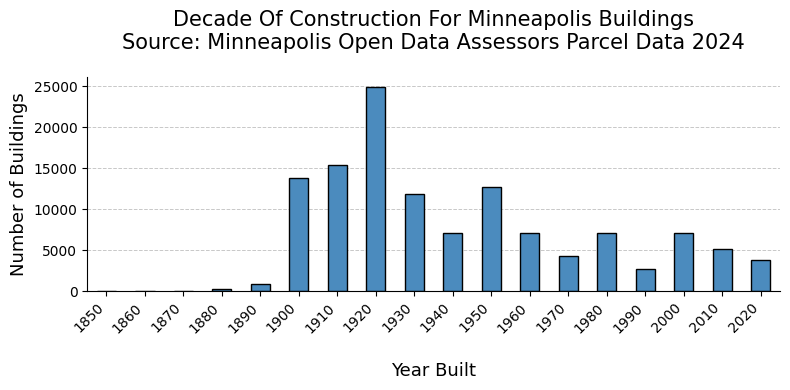

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
summary = (
    round(df.query("YEARBUILT>1700")["YEARBUILT"].astype(int), -1)
    .value_counts()
    .sort_index()
)
bars = summary.plot(
    kind="bar", edgecolor="black", grid=True, zorder=2, ax=ax, color="#4B8BBE"
)
ax.set_xlabel("\nYear Built", fontsize=13)
ax.set_ylabel("Number of Buildings", fontsize=13)
ax.set_title(
    "Decade Of Construction For Minneapolis Buildings\nSource: Minneapolis Open Data Assessors Parcel Data 2024",
    fontsize=15,
    pad=20,
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


#####<br>That's a cool chart and pandas is very powerful. So why use Databricks notebooks, or PySpark? What does that buy us?

#####Consider a deceptively complex question: "How do neighboring buildings impact parcel values?" To answer this question, we need to perform nearest neighbor search. The simplest way to do this is by computing pairwise distance for Minneapolis's 133k properties.

#####That operation creates a grid of 133k x 133k values, each with 8 bytes—almost 40GB of data, more than we can fit into RAM.

In [0]:
from scipy.spatial.distance import pdist, squareform
import pandas as pd
#Convert df to numpy for distance matric function
coords = df[['X', 'Y']].dropna().to_numpy()
#pdist gets matrix
dist_matrix = pdist(coords, metric='euclidean')


---------------------------------------------------------------------------
The Python process exited with exit code 137 (SIGKILL: Killed). This may have been caused by an OOM error. Check your command's memory usage.



The last 10 KB of the process's stderr and stdout can be found below. See driver logs for full logs.
---------------------------------------------------------------------------
Last messages on stderr:
Mon Jul 28 11:24:42 2025 Connection to spark from PID  2479
Mon Jul 28 11:24:42 2025 Initialized gateway on port 40647
Mon Jul 28 11:24:42 2025 Connected to spark.
---------------------------------------------------------------------------
Last messages on stdout:
NOTE: When using the `ipython kernel` entry point, Ctrl-C will not work.

To exit, you will have to explicitly quit this process, by either sending
"quit" from a client, or using Ctrl-\ in UNIX-like environments.

To read more about this, see https://github.com/ipython/ipython/issues/2049


To connect another c


#####<br>And we have successfully crashed Python! But fret not. We are using Databricks, so we can easily benefit from Spark.

In [0]:
from pyspark.sql import functions as F

In [0]:
# Turn pandas DF to spark DF
df_spark = spark.createDataFrame(df.dropna(subset = ['PIN', 'X', 'Y',"BUILDINGUSE","BLDGVALUE"]))

# Aliasing for cross join
df1 = df_spark.selectExpr("PIN as PIN1", "X as X1", "Y as Y1","BUILDINGUSE as B1USE","BLDGVALUE AS BLDGVALUE")
df2 = df_spark.selectExpr("PIN as PIN2", "X as X2", "Y as Y2")

# Filter to avoid self-pairing
df_cross = df1.crossJoin(df2).filter("PIN1 != PIN2")

# Compute Euclidean distance
df_cross = df_cross.withColumn(
    "dist",
F.sqrt((F.col("X1") - F.col("X2"))**2 + (F.col("Y1") - F.col("Y2"))**2)
)
# Get the nearest neighbor distance per parcel and convert to pandas to cache the result
nearest_neighbors = df_cross.\
    groupBy("PIN1", "B1USE", "BLDGVALUE").agg(
    F.min("dist").alias("nearest_dist"),
    F.min_by("PIN2", "dist").alias("nearest_PIN")
).toPandas()


In [0]:
df2=df.dropna(subset = ['PIN', 'X', 'Y',"BUILDINGUSE","BLDGVALUE"]).\
    rename(columns={'PIN':'nearest_PIN',"BUILDINGUSE":'B2USE'})[['nearest_PIN','B2USE']]

# And it ran! 🥳
#### Not only that- it ran in a reasonable amount of time :D
#### Now we can start interrogating this data!

# 🏡 Nimby Analysis Time! 🏢 
##### Does being next door to a larger apartment building decrease your home value?

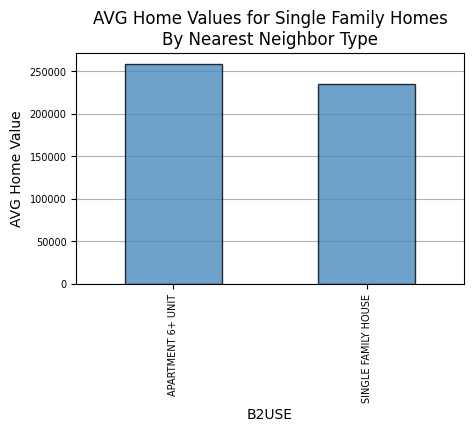

In [0]:
nearest_neighbors.merge(df2,on='nearest_PIN').\
    query('B1USE=="SINGLE FAMILY HOUSE"').\
    query('B2USE=="APARTMENT 6+ UNIT" | B2USE=="SINGLE FAMILY HOUSE"').\
    groupby('B2USE')['BLDGVALUE'].\
    agg(['mean','size']).\
    sort_values('mean',ascending=False)['mean'].\
    plot(kind='bar',
         edgecolor='black',
         grid=True,color='#4B8BBE',
         zorder=2,
         alpha=.8,
         figsize=(5,3),
         fontsize=7,
         ylabel='AVG Home Value',
         title='AVG Home Values for Single Family Homes\nBy Nearest Neighbor Type').xaxis.grid(False)

###<br> 🤔 Is this enough evidence to convert Nimbies to Yimbies? 🏡➡️🏢
### <br>🔍 What can we do to more conclusively answer this question? 📊
##### 🤝 Meet us at Twin Cities Data Science & Analytics to explore deeper!
##### 📅 August 13 | 🕕 6:00–8:00 PM | 📍 Improving, Minneapolis



#<br> Make sure to RSVP!!👇
# [https://lnkd.in/gGdg25wK]()

# 🫡
##### Signing Off, 
##### Data Dan 